# US Senators dataset

## Students

* Team: `18`
* Students: ` Quentin Bacuet, Ali Alami-Idrissi, Keshav Singh, Leandro Kieliger`
* Dataset: `US-Senators`

## Imports

In [121]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
from scipy import sparse
from pygsp import graphs, reduction
from scipy import linalg
from sklearn.cluster import KMeans
from pyunlocbox import functions, solvers
import networkx as nx
from IPython.display import display, HTML
from pyunlocbox import functions, solvers

from helpers import *
from solver import *
from cluster import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load processed data

In [2]:
votes = pd.read_pickle("data/processed/processed_votes.pickle")
print(votes.shape)
display(votes.index)

(105, 18)


Index(['A000360', 'B000575', 'B000944', 'B001135', 'B001230', 'B001236',
       'B001261', 'B001267', 'B001277', 'B001288',
       ...
       'T000464', 'T000476', 'U000039', 'V000128', 'W000437', 'W000779',
       'W000802', 'W000805', 'W000817', 'Y000064'],
      dtype='object', name='member_id', length=105)

## Load labels

## Building the similarity graph

In [3]:
features = [votes.values[:,:]]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_limit(sparsify_with_max_neighbors(arg, 6),0.55)]

adjacency = get_adjacency_multidistance(features, weights, cosine_similarity, lambda x:x, sparsification_functions)
senators = pd.read_pickle("data/processed/processed_senators.pickle")
labels_text = senators['party']
labels = np.load("data/processed/processed_labels_numerical.npy")
argsort_labels = np.argsort(labels)

"""
# Remove nodes without neighbors
node_degrees = np.count_nonzero(adjacency, axis=1)
nodes_to_keep = np.nonzero(node_degrees)[0]
adjacency = adjacency[nodes_to_keep,:][:,nodes_to_keep]

labels_kept = labels[nodes_to_keep]
"""

def build_coordinates():
    coord = []
    for a in np.linspace(0, np.pi / 2.0 - 0.3, 10):
        for r in np.linspace(2,7,5): 
            coord.append([r * np.cos(a), r * np.sin(a)])
       
    for a in np.linspace(np.pi / 2.0 + 0.3, np.pi, 11):
        for r in np.linspace(2,7,5):    
            coord.append([r * np.cos(a), r * np.sin(a)])
            
    return coord

coord = np.array(build_coordinates())

[]


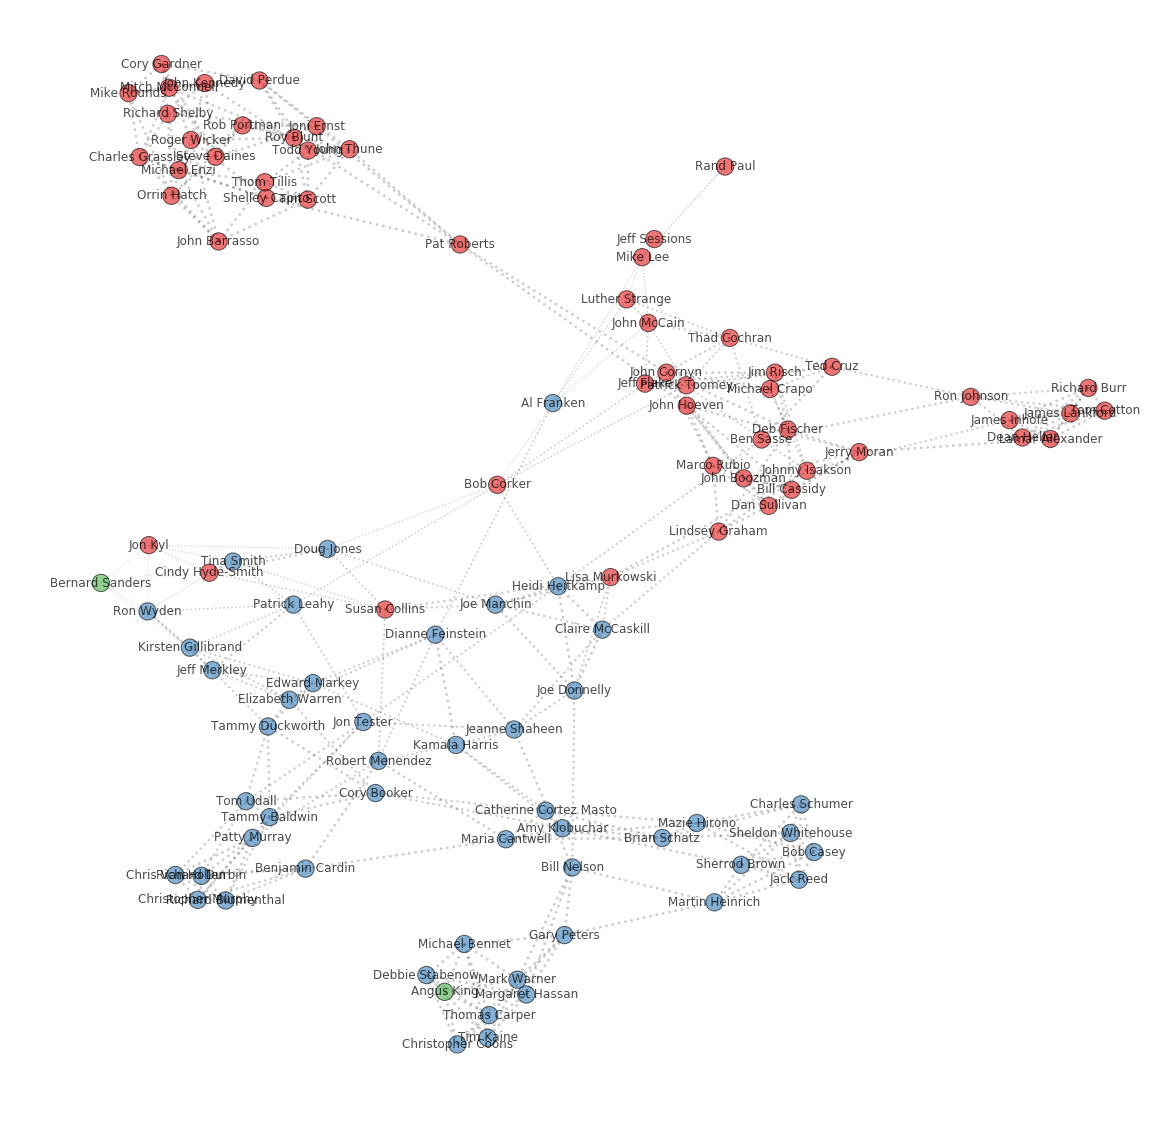

In [4]:
plt.figure(figsize=(20,20))
plot_signal(adjacency, labels, labels=senators['name'], scale=[0,1])
plt.show()

## Get best bills

In [5]:
k = 3

In [6]:
features_bills = [votes.T.values[:,:]]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_limit(arg,0.7)]

adjacency_bills = get_adjacency_multidistance(features_bills, weights, cosine_similarity, lambda x:x, sparsification_functions)

[]


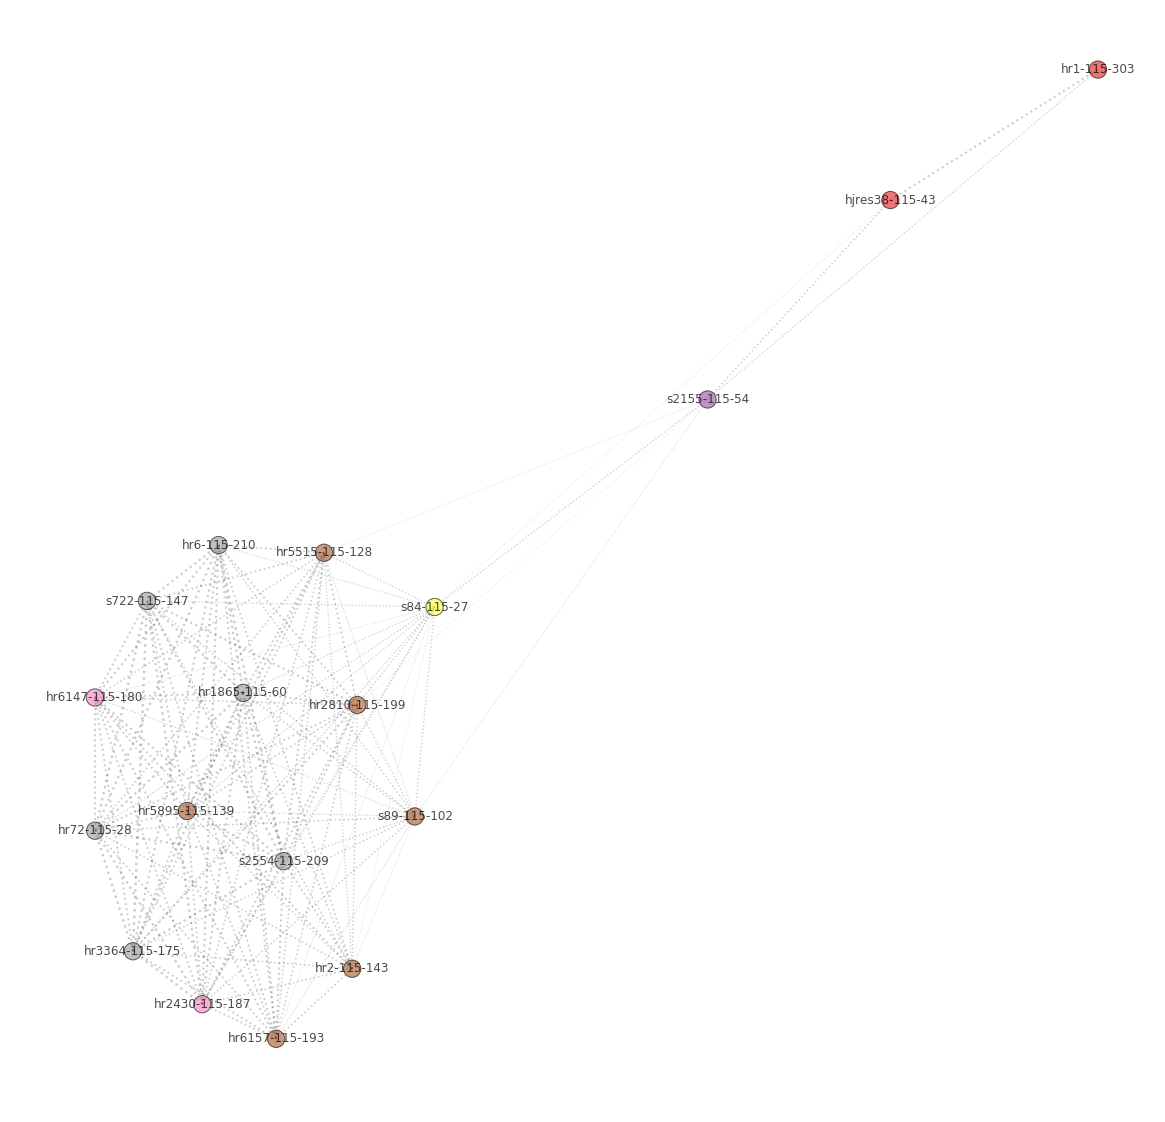

In [7]:
plt.figure(figsize=(20,20))
plot_signal(adjacency_bills, votes.sum(0) / votes.shape[0], labels=votes.T.index, scale=[0,1])
plt.show()

### Method 1: Get biggest Variance

In [8]:
var = np.zeros(votes.shape[1])

for i in range(votes.shape[1]):
    a = votes.values[:,i]
    var[i] = np.var(a[a != 0])
    
best_bills = var.argsort()[-k:]
best_bills

array([13,  0,  1])

### Method 2: Get smallest number of neighbors

In [9]:
temp = adjacency_bills.copy()
temp[temp > 0] = 1
best_bills = temp.sum(0).argsort()[:k]
best_bills

array([ 1,  0, 13])

### Method 3: Get closest points of the centers of the cluster of the Bills

In [10]:
G = nx.from_numpy_matrix(adjacency_bills)
laplacian_bills = nx.laplacian_matrix(G).todense()

eigenvalues = embed(laplacian_bills,k)
clusters,centers = gen_kmeans(eigenvalues,k)
best_bills = np.zeros(k)

for j in range(k):
    min_ = 1000;
    for i in range(eigenvalues.shape[0]):
        dist = np.linalg.norm(eigenvalues[i] - centers[j])
        if dist < min_:
            min_ = dist
            best_bills[j] = i

In [11]:
best_bills

array([17.,  1.,  0.])

### Method 4: Get the bills with biggest intracluster std

In [89]:
var = np.zeros(votes.shape[1])
rep_indexes = np.nonzero(labels == 0)[0]
dem_indexes = np.nonzero(labels == 0.12)[0] 
rep_data = votes.iloc[rep_indexes]
dem_data = votes.iloc[dem_indexes]
rep_std = np.apply_along_axis(lambda x : np.std(x[x!=0]),0,rep_data.values)
dem_data = np.apply_along_axis(lambda x : np.std(x[x!=0]),0,dem_data.values)
stds = (rep_std+dem_data)/2

best_bills = stds.argsort()[-k:]
best_bills

array([ 5,  7, 17])

In [90]:
stds

array([0.42041972, 0.13733516, 0.28430489, 0.41724588, 0.        ,
       0.52207014, 0.13733516, 0.56225979, 0.4586858 , 0.13864839,
       0.32780364, 0.33678116, 0.        , 0.47628048, 0.19410774,
       0.13733516, 0.47628048, 0.61169889])

## Embedding you in the graph

In [91]:
bill_selection = best_bills.astype(int)
your_votes = [-1,-1,-1]

other_senators_vote = votes.values[:,bill_selection]

In [92]:
def compute_similarity(senator_votes):
    return euclidean_distance(senator_votes, your_votes)

similarity_vector = np.apply_along_axis(compute_similarity, 1, other_senators_vote)
similarity_vector = sparsify_with_limit(gaussian_kernel(similarity_vector),0.6)
similarity_vector

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.73483665, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.6631133 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.6631133 ,
       0.        , 0.        , 0.        , 0.        , 0.66311

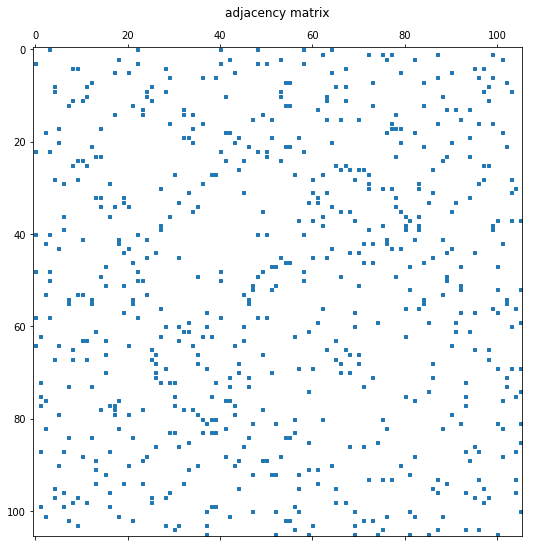

In [93]:
new_columns = np.append(similarity_vector, 0)

n = len(adjacency)
new_adjacency = np.zeros((n+1, n+1))
new_adjacency[:n,:n] = adjacency
new_adjacency[n,:] = new_columns
new_adjacency[:,n] = new_columns

new_labels = np.append(senators['name'].values, ['you'])

plot_adjacency(new_adjacency)

['you']


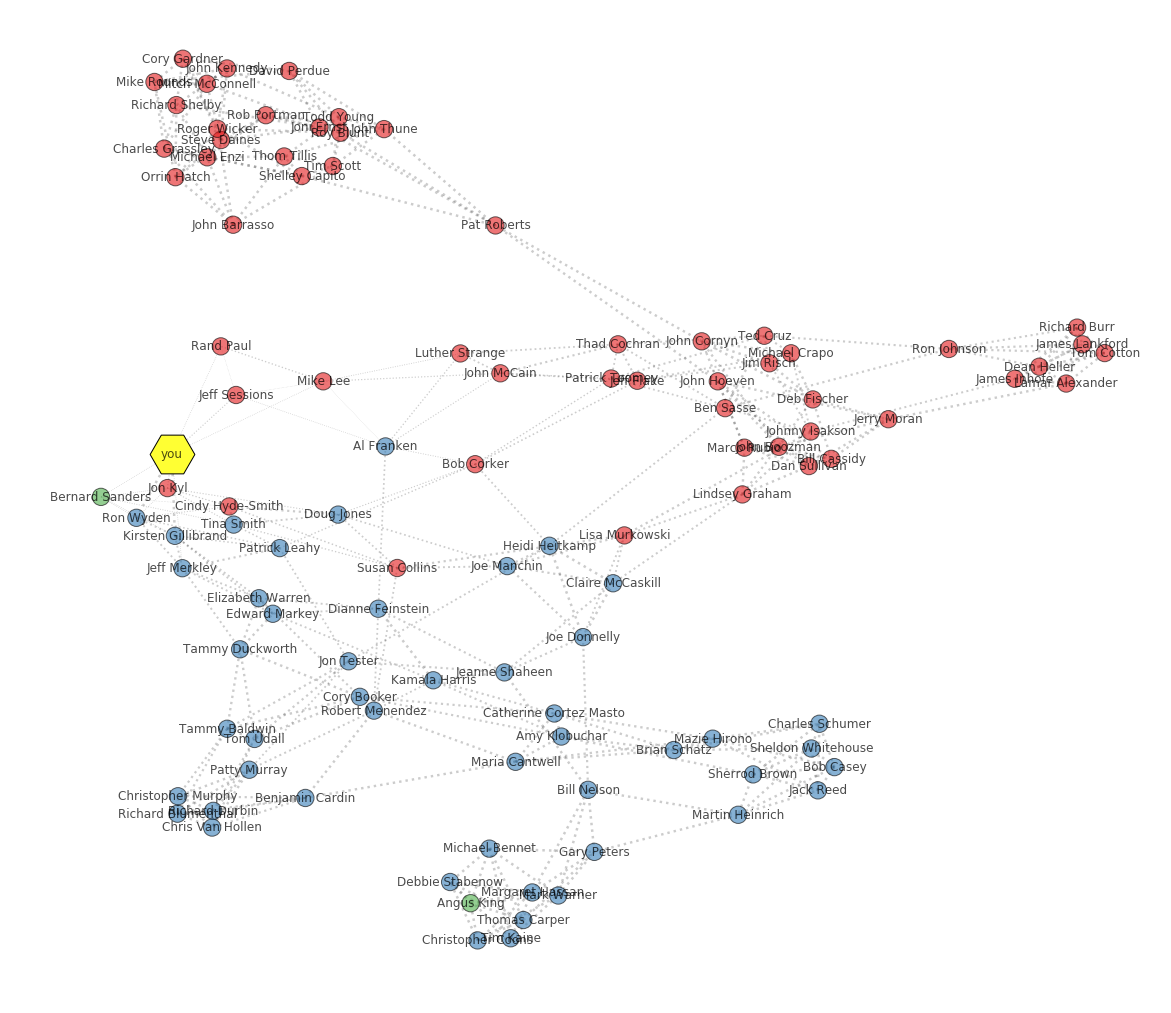

In [94]:
plt.figure(figsize=(20,18))

pos = dict(zip(senators['name'].values[argsort_labels], coord))
pos['you'] = [0,0]

plot_signal(new_adjacency, np.append(labels, [0]), labels=new_labels, scale=[0,1], highlight_node=[105])
plt.show()

## Spectral analysis of the new adjacency matrix

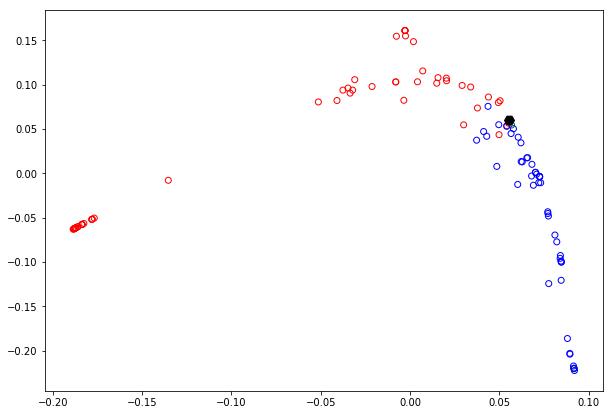

In [95]:
G = graphs.Graph(new_adjacency)
G.set_coordinates('spring', seed=2018)
G.compute_fourier_basis()
G.compute_laplacian()

embedding = G.U[:,1:3]

colors = {'R':'red','D':'blue','I':'green'}

plt.figure(figsize=(10,7))

n = len(embedding)
for i in range(n-1):
    plt.scatter(embedding[i,0], embedding[i,1], facecolors='none', edgecolors=colors[labels_text[i]])
    
plt.scatter(embedding[n-1,0], embedding[n-1,1], color='black', s=100, marker='H')
plt.show()

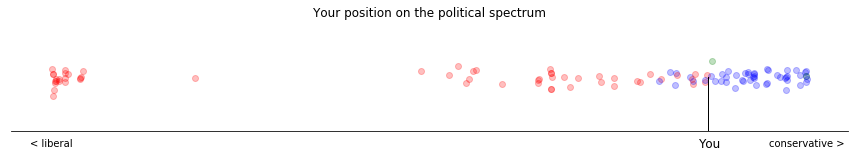

In [96]:
from scipy.stats import gaussian_kde

fig = plt.figure(figsize=(15,2))
ax = plt.subplot(111)
ax.set_title("Your position on the political spectrum")

for i in range(n-1):
    ax.scatter(embedding[i,0], np.random.normal(.5,.05), alpha=0.25, color=colors[labels_text[i]])
    
#ax.scatter(embedding[n-1,0], embedding[n-1,1], color='black', s=100, marker='H')
density = gaussian_kde(embedding[:,0])
xs = np.linspace(np.min(embedding[:,0]),np.max(embedding[:,0]),100)


#ax.plot(xs, density(xs))
ax.set_xticks([np.min(embedding[:,0]),np.max(embedding[:,0])])
ax.set_ylim([0,1])
ax.set_xticklabels(['< liberal','conservative >'])
plt.tick_params(axis='x', which='both', bottom=False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot([embedding[n-1,0], embedding[n-1,0]], [0, 0.5], 'k-', lw=1)

plt.text(embedding[n-1,0] - 0.0035, -0.15, "You", fontsize=12)
plt.show()

# Predicting votes based on votes from similar senators

[]


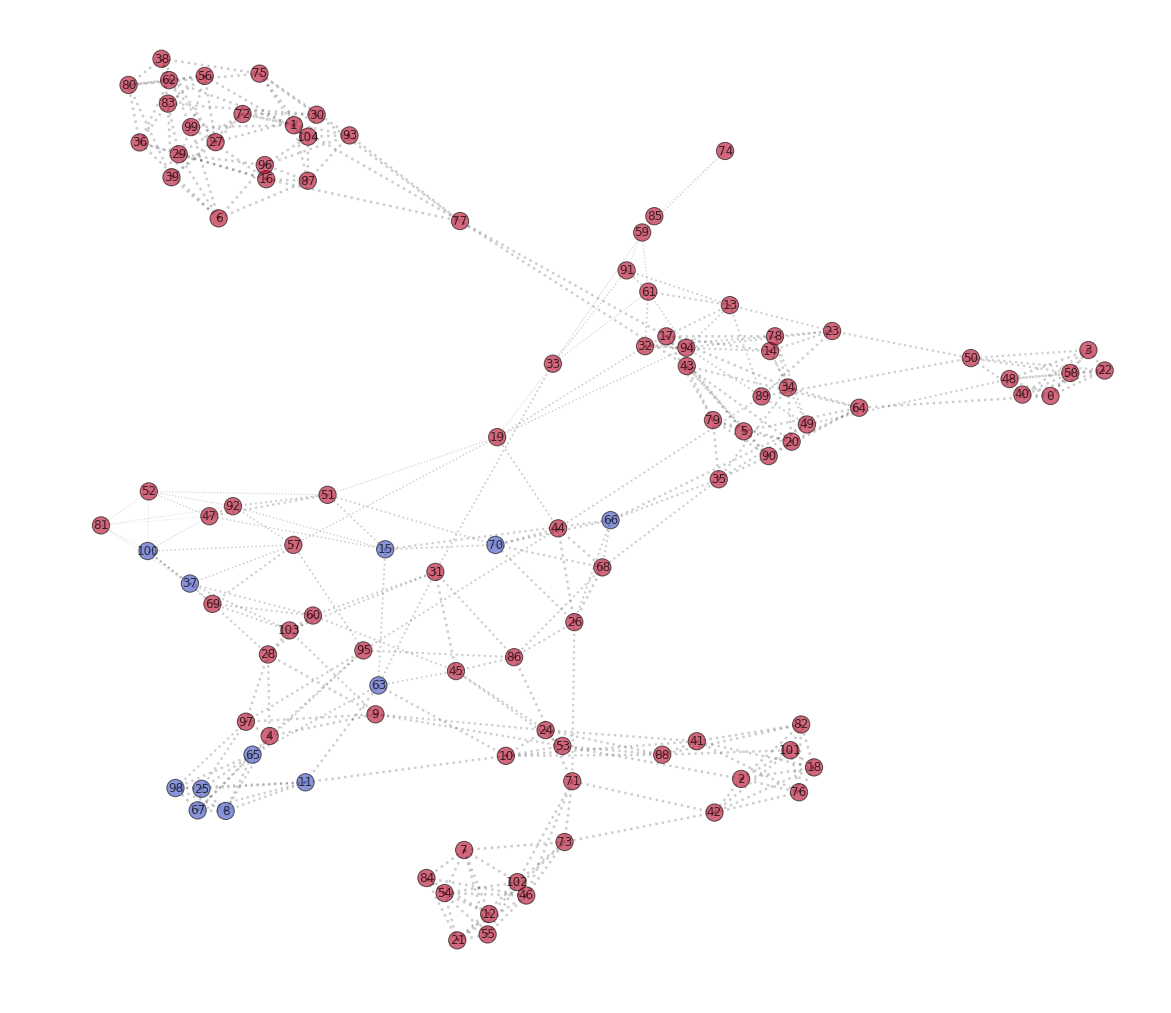

In [100]:
# Binarize labels

def get_labels(feature_vector):
    labels = feature_vector.copy()
    labels[labels>=0] = 1
    labels[labels<0] = -1
    
    return labels

labels_bin = get_labels(votes.values[:,votes.values.shape[1]-1])
n = len(labels)

mn_ratio = 0.3 # Ratio of node labels to keep
m = int(mn_ratio * n)  # Number of measurements.

def get_mask(m):
    idx = np.random.choice(np.arange(n),m,replace=False)
    w = np.zeros(n)
    w[idx] = 1
    return w


w = get_mask(m)

plt.figure(figsize=(20,18))
plot_signal(adjacency, labels_bin, scale=[-1,1], colormap=plt.get_cmap('coolwarm'))
plt.show()

In [125]:
def get_signal_predicted(adjacency,mask,labels_bin,threshold = 0,number_of_trials=10,verbose = 'NONE'):
    G = graphs.Graph(adjacency)
    G.set_coordinates('spring', seed=2018)
    G.compute_fourier_basis()
    G.compute_differential_operator()
    G.compute_laplacian()
    sol_2norm_min = None
    for _ in range(number_of_trials):
        tmp = graph_pnorm_interpolation(sparse.csr_matrix(G.D),P_wrapper(w, labels_bin),np.random.randn(n),2,verbosity=verbose)
        if sol_2norm_min is not None:
            sol_2norm_min += tmp
        else:
            sol_2norm_min = tmp

    sol_2norm_bin = get_thresholded_values(sol_2norm_min/number_of_trials,threshold)
    return sol_2norm_bin

0.4364357804719848
[]


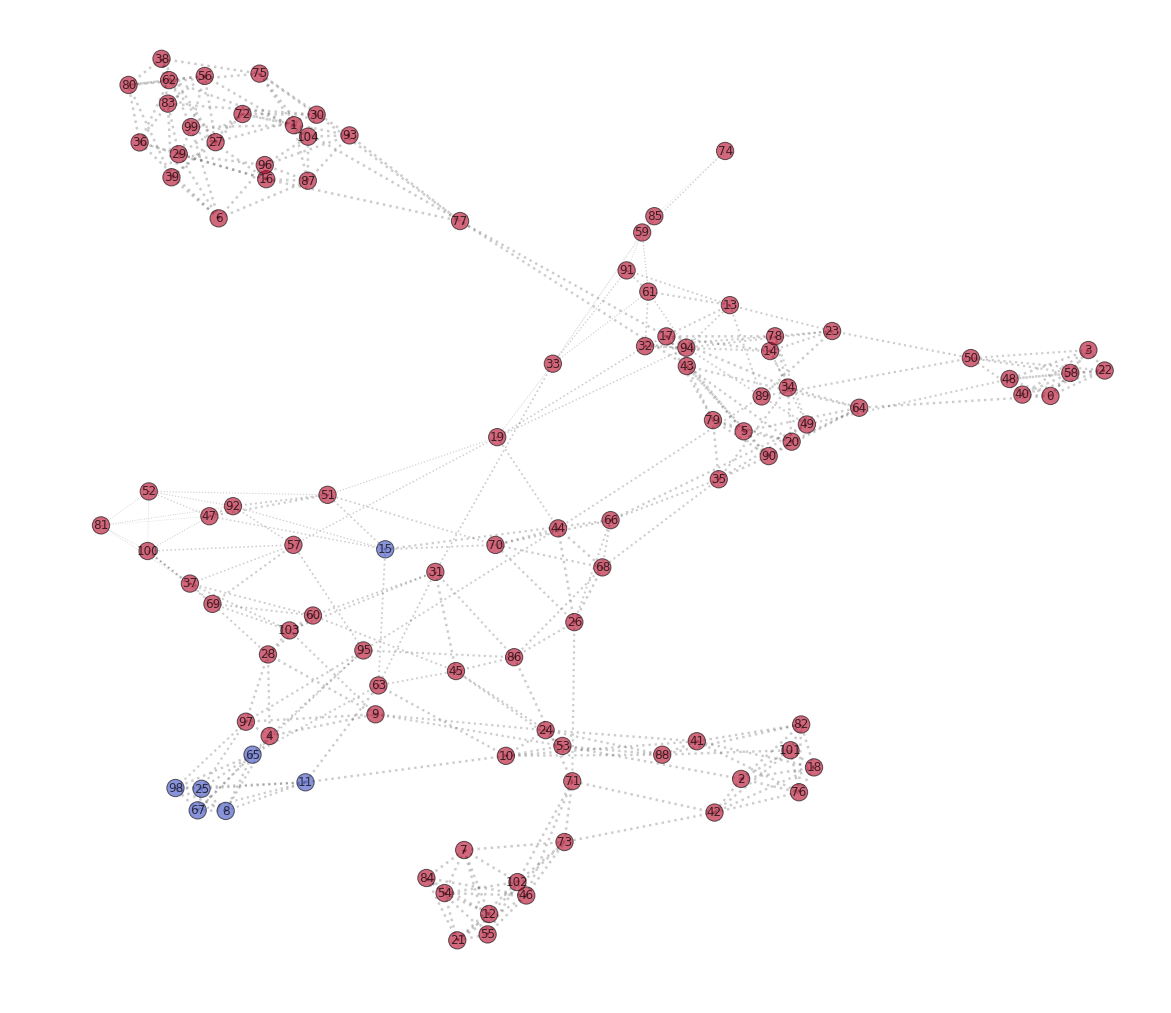

In [126]:
sol_2norm_bin =  get_signal_predicted(adjacency,w,labels_bin)

plt.figure(figsize=(20,18))
print(error(labels_bin, sol_2norm_bin))
plot_signal(adjacency, sol_2norm_bin, scale=[-1,1], colormap=plt.get_cmap('coolwarm'))
plt.show()

# What about you ?


In [21]:
def get_gradient(adjacency):
    G = graphs.Graph(adjacency)
    G.compute_differential_operator()
    return sparse.csr_matrix(G.D)

def get_mask_TA(n,idx):
    w = np.zeros(n)
    w[idx] = 1
    return w.astype(int)

def predict_votes(bill_id,p = 2,number_of_trials = 500):
    bill_votes = np.append(votes.values[:,bill_id],0)

    idx = np.argwhere(bill_votes!=0)
    w = get_mask_TA(n+1,idx)    
    sol_norm_min = np.zeros(n+1)
    
    for i in range(number_of_trials):
        sol_norm_min += graph_pnorm_interpolation(get_gradient(new_adjacency),P_wrapper(w, bill_votes),np.random.randn(n+1),p,verbosity='NONE') / number_of_trials
        
    print(sol_norm_min[-1])
    return get_thresholded_values(sol_norm_min,0)

sol_norm_min = predict_votes(13)
sol_norm_min[-1]

-0.7262475305278047


-1.0

In [22]:
def get_closest_senators_id(adjacency,number_of_senators):
        close_senators = adjacency[-1,:].copy()
        close_senators = close_senators[close_senators > 0]
        num = min(number_of_senators,close_senators.shape[0])
        return np.argsort(adjacency[-1,:])[-num:]

get_closest_senators_id(new_adjacency,3)

array([100,  63,  37])

# Going further, can we predict the voting outcome based on votes of swing senators ?

Swing senators are those thank link the democratic and republican clusters

In [140]:
## Identifying swing votes
def swing_scores(adjacency,labels):
    similarity_mask = (np.repeat(labels[np.newaxis,:],adjacency.shape[0],axis=0) != labels [:,np.newaxis])
    weights_sum = adjacency.sum(1)
    swing_score = (similarity_mask*adjacency).sum(1)
    swing_score /= weights_sum
    return swing_score
    
    
swing_senators = np.nonzero(swing_scores(adjacency,labels) > 0.5)[0]
non_swing_senators = np.nonzero(swing_scores(adjacency,labels) <= 0.5)[0]
accuracies = []
for i in range(votes.values.shape[1]):
    labels_bin = get_labels(votes.values[:,i])
    labels_bin[non_swing_senators] = 1
    pred = get_signal_predicted(adjacency,swing_senators,labels_bin)
    accuracies.append(accuracy(pred,labels_bin))

In [139]:
accuracies

[0.9714285714285714,
 1.0,
 0.9523809523809523,
 0.9619047619047619,
 0.9619047619047619,
 0.9809523809523809,
 0.9714285714285714,
 0.9619047619047619,
 0.9428571428571428,
 0.9523809523809523,
 0.9523809523809523,
 0.9523809523809523,
 0.9523809523809523,
 0.9714285714285714,
 0.9428571428571428,
 0.9619047619047619,
 0.9619047619047619,
 0.9523809523809523]

In [132]:
swing_senators

(array([15, 19, 33, 47, 51, 52, 54, 81, 92]),)